## **ALNS + Deep Q-Learning**

**ASK**

- Train Model 'Learn-to-Solve' -> Có data mới thì phải tốn time train mới xài được???

- Đang làm framework

**NOTE 12/11**

- chạy DQN-Learning trước, dùng kết quả đó chạy với ALNS

- VRPTW - thỏa mãn khách hàng nhận được hàng trong time nhất định.

- input: có thể điều chỉnh số xe.


<br>

- lưu model.safetensor

- số vehicles, total distance, average cost


<br>

- chức năng quản lý
- trực quan - khởi tạo bản đồ
- 1-20 routes trên web. Show được model chọn routes



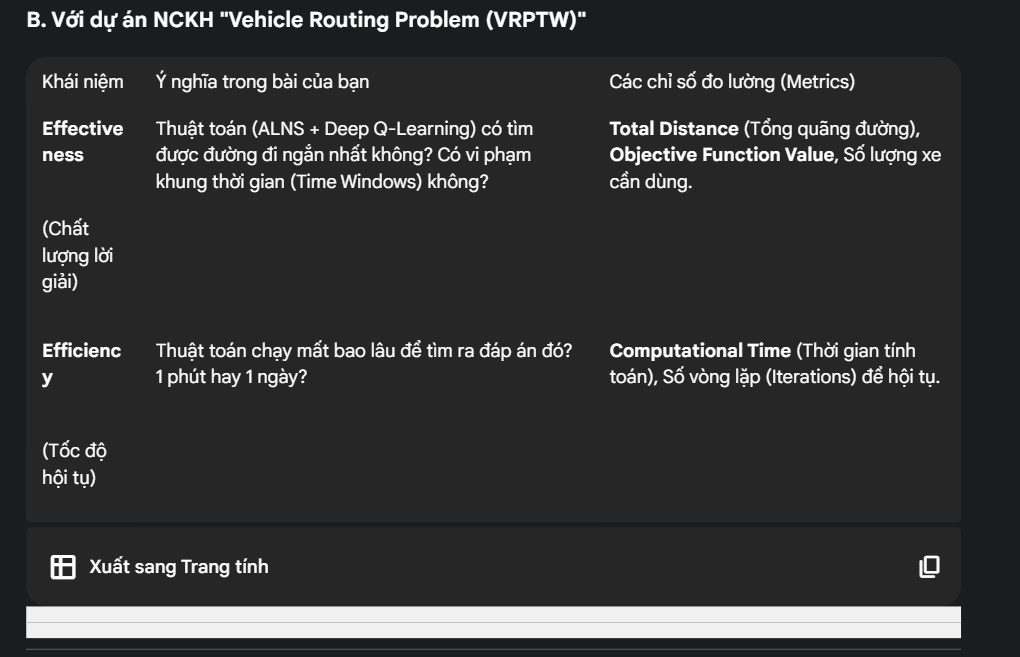

### **Load Datasets from Kaggle**

[VRPTW Benchmark Datasets](https://www.kaggle.com/datasets/senju14/vrptw-benchmark-datasets)

In [ ]:
import kagglehub, shutil

# Download latest version
path = kagglehub.dataset_download("senju14/vrptw-benchmark-datasets")
print("Path to dataset files:", path)

shutil.move(path, '/content/vrptw-benchmark')
print('Done')

100%|██████████| 2.49M/2.49M [00:01<00:00, 2.21MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/senju14/vrptw-benchmark-datasets/versions/1
Done


In [ ]:
!ls /content/vrptw-benchmark/data/Solomon

c101.txt  c109.txt  c208.txt  r108.txt	r204.txt  rc101.txt  rc201.txt
c102.txt  c201.txt  r101.txt  r109.txt	r205.txt  rc102.txt  rc202.txt
c103.txt  c202.txt  r102.txt  r110.txt	r206.txt  rc103.txt  rc203.txt
c104.txt  c203.txt  r103.txt  r111.txt	r207.txt  rc104.txt  rc204.txt
c105.txt  c204.txt  r104.txt  r112.txt	r208.txt  rc105.txt  rc205.txt
c106.txt  c205.txt  r105.txt  r201.txt	r209.txt  rc106.txt  rc206.txt
c107.txt  c206.txt  r106.txt  r202.txt	r210.txt  rc107.txt  rc207.txt
c108.txt  c207.txt  r107.txt  r203.txt	r211.txt  rc108.txt  rc208.txt


In [ ]:
!ls /content/vrptw-benchmark/data/Gehring_Homberger/

homberger_1000_customer_instances  homberger_600_customer_instances
homberger_200_customer_instances   homberger_800_customer_instances
homberger_400_customer_instances


In [ ]:
import os

def show_directory_tree(startpath):
    """Hiển thị cây thư mục"""
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:10]:
            print(f"{subindent}{file}")
        if len(files) > 10:
            print(f"{subindent}... và {len(files) - 10} file khác")

# Hiển thị cây thư mục
show_directory_tree("/content/vrptw-benchmark")

vrptw-benchmark/
  data/
    Gehring_Homberger/
      homberger_1000_customer_instances/
        R1_10_2.TXT
        RC2_10_5.TXT
        RC2_10_7.TXT
        R1_10_4.TXT
        RC1_10_6.TXT
        C1_10_5.TXT
        R1_10_1.TXT
        RC2_10_2.TXT
        RC2_10_8.TXT
        RC1_10_5.TXT
        ... và 50 file khác
      homberger_400_customer_instances/
        RC1_4_7.TXT
        RC2_4_3.TXT
        RC1_4_2.TXT
        RC1_4_1.TXT
        RC1_4_4.TXT
        R1_4_9.TXT
        C2_4_4.TXT
        RC2_4_6.TXT
        RC2_4_9.TXT
        C2_4_6.TXT
        ... và 50 file khác
      homberger_600_customer_instances/
        R2_6_3.TXT
        RC2_6_2.TXT
        RC2_6_9.TXT
        C2_6_5.TXT
        C1_6_7.TXT
        R1_6_7.TXT
        R2_6_9.TXT
        C2_6_2.TXT
        R2_6_7.TXT
        C1_6_5.TXT
        ... và 50 file khác
      homberger_800_customer_instances/
        C2_8_2.TXT
        RC2_8_2.TXT
        R1_8_1.TXT
        R1_8_10.TXT
        C2_8_10.TXT
        C1_8_9

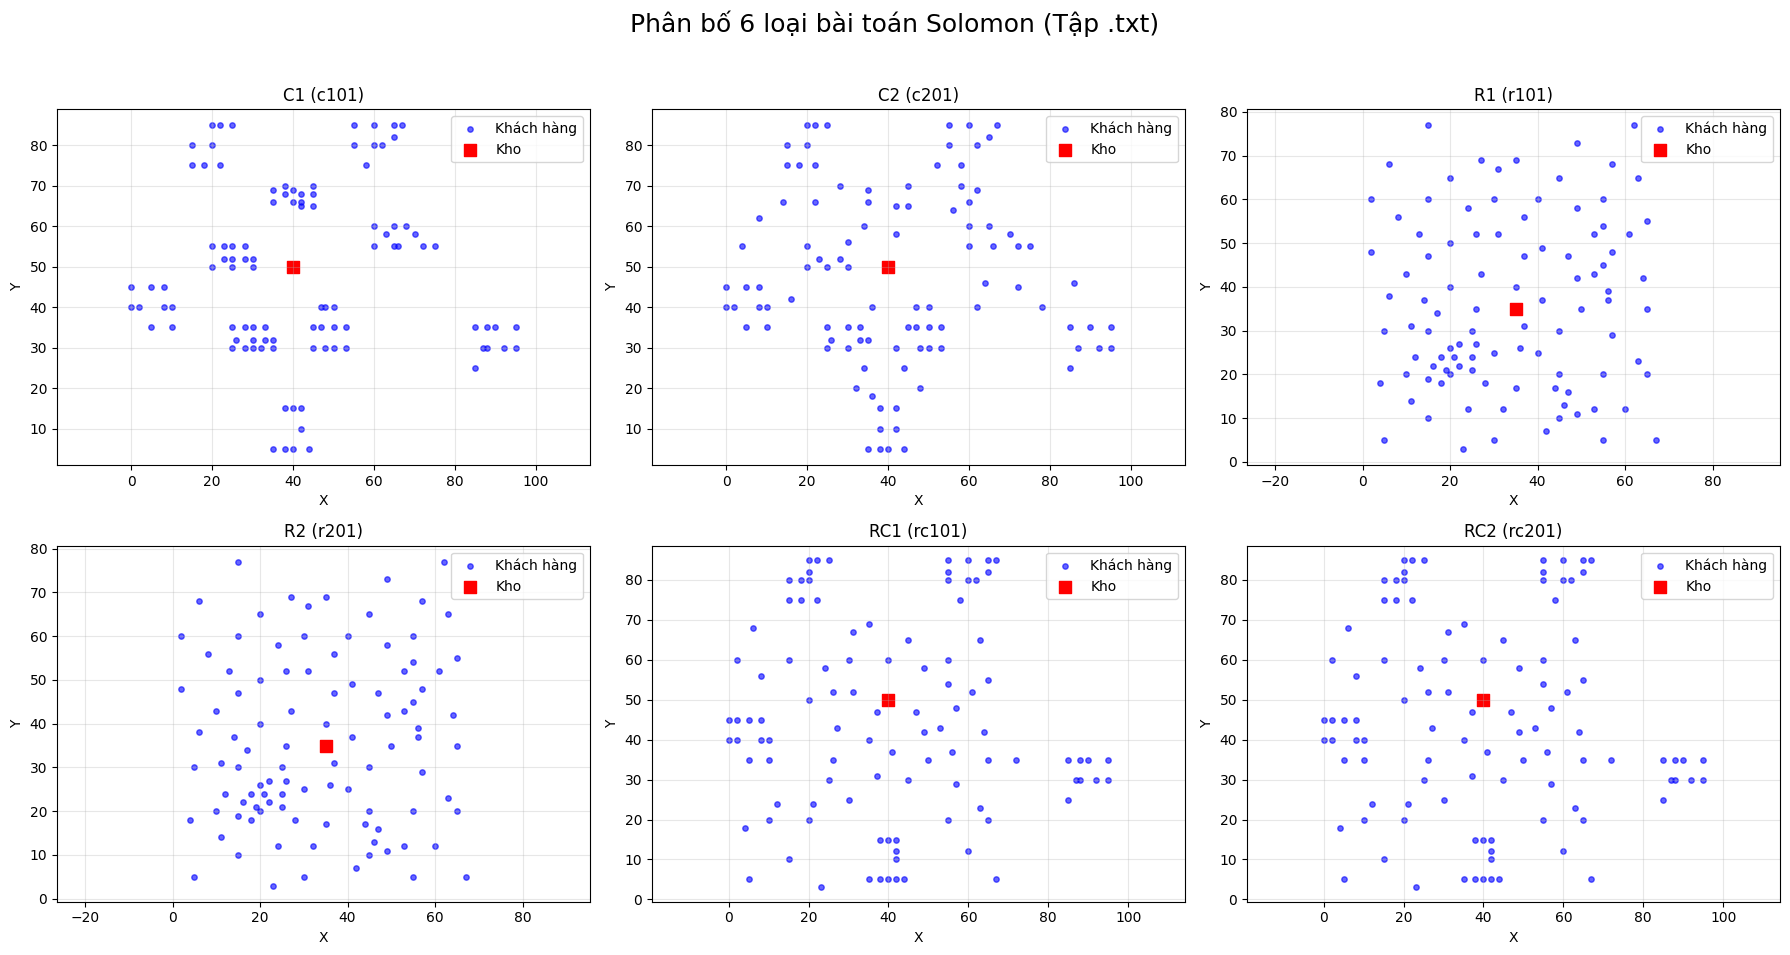

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def read_benchmark_file(file_path):
    """
    Hàm parser (phân tích) file .txt mạnh mẽ,
    đọc được cả Solomon và Homberger.
    """
    lines = []
    with open(file_path, 'r') as f:
        lines = f.readlines()

    vehicle_capacity = 200.0 # Mặc định
    customer_data = []
    header_found = False

    # --- 1. Tìm Capacity (hoạt động cho cả 2 loại) ---
    for i, line in enumerate(lines):
        line_upper = line.upper()
        if "CAPACITY" in line_upper:
            # Thử lấy capacity từ dòng hiện tại (Solomon)
            parts = line.split()
            if len(parts) > 1 and parts[1].isdigit():
                vehicle_capacity = float(parts[1])
                break
            # Thử lấy capacity từ dòng tiếp theo (Homberger)
            if i + 1 < len(lines):
                parts_next = lines[i+1].split()
                if len(parts_next) > 0 and parts_next[-1].isdigit():
                    vehicle_capacity = float(parts_next[-1])
                    break

    # --- 2. Tìm và Phân tích Dữ liệu Khách hàng ---
    for line in lines:
        line_strip = line.strip()

        if not line_strip: # Bỏ qua dòng trống
            continue

        # Đánh dấu khi tìm thấy header
        if "CUST NO." in line_strip.upper():
            header_found = True
            continue # Bỏ qua chính dòng header

        # Nếu đã tìm thấy header, bắt đầu đọc data
        if header_found:
            parts = line_strip.split()
            # Dòng data phải có ít nhất 7 phần tử và phần tử đầu là số
            if len(parts) >= 7 and parts[0].isdigit():
                customer_data.append({
                    'CUST_NO': int(parts[0]),
                    'XCOORD': float(parts[1]),
                    'YCOORD': float(parts[2]),
                    'DEMAND': float(parts[3]),
                    'READY_TIME': float(parts[4]),
                    'DUE_TIME': float(parts[5]), # Tương ứng với DUE DATE
                    'SERVICE_TIME': float(parts[6]) # Tương ứng với SERVICE TIME
                })

    if not customer_data:
        print(f"Lỗi: Không đọc được data từ {file_path}")
        return pd.DataFrame(), None

    df = pd.DataFrame(customer_data)
    # Trả về cả capacity vì hàm này sẽ được dùng lại sau
    return df, vehicle_capacity

# --- 1. Cấu hình đường dẫn và file ---
BASE_PATH_SOLOMON = 'vrptw-benchmark/data/Solomon/'

# (Bạn phải đảm bảo 6 file .txt này tồn tại)
files_to_plot = {
    'C1 (c101)': 'c101.txt',
    'C2 (c201)': 'c201.txt',
    'R1 (r101)': 'r101.txt',
    'R2 (r201)': 'r201.txt',
    'RC1 (rc101)': 'rc101.txt',
    'RC2 (rc201)': 'rc201.txt',
}

# --- 2. Vẽ 6 loại bài toán ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phân bố 6 loại bài toán Solomon (Tập .txt)', fontsize=18)
axes = axes.flatten()

for i, (plot_title, fname) in enumerate(files_to_plot.items()):
    ax = axes[i]
    file_path = os.path.join(BASE_PATH_SOLOMON, fname)

    if not os.path.exists(file_path):
        ax.set_title(f"{plot_title} (Không tìm thấy)", color='red')
        ax.axis('off')
        continue

    # Dùng hàm parser mới
    df, _ = read_benchmark_file(file_path)

    if df.empty:
        ax.set_title(f"{plot_title} (Lỗi đọc)", color='red')
        ax.axis('off')
        continue

    depot = df[df['CUST_NO'] == 0].iloc[0]
    customers = df[df['CUST_NO'] != 0]

    ax.scatter(customers['XCOORD'], customers['YCOORD'], c='blue', s=15, alpha=0.6, label='Khách hàng')
    ax.scatter(depot['XCOORD'], depot['YCOORD'], c='red', s=80, marker='s', label='Kho')

    ax.set_title(f'{plot_title}', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

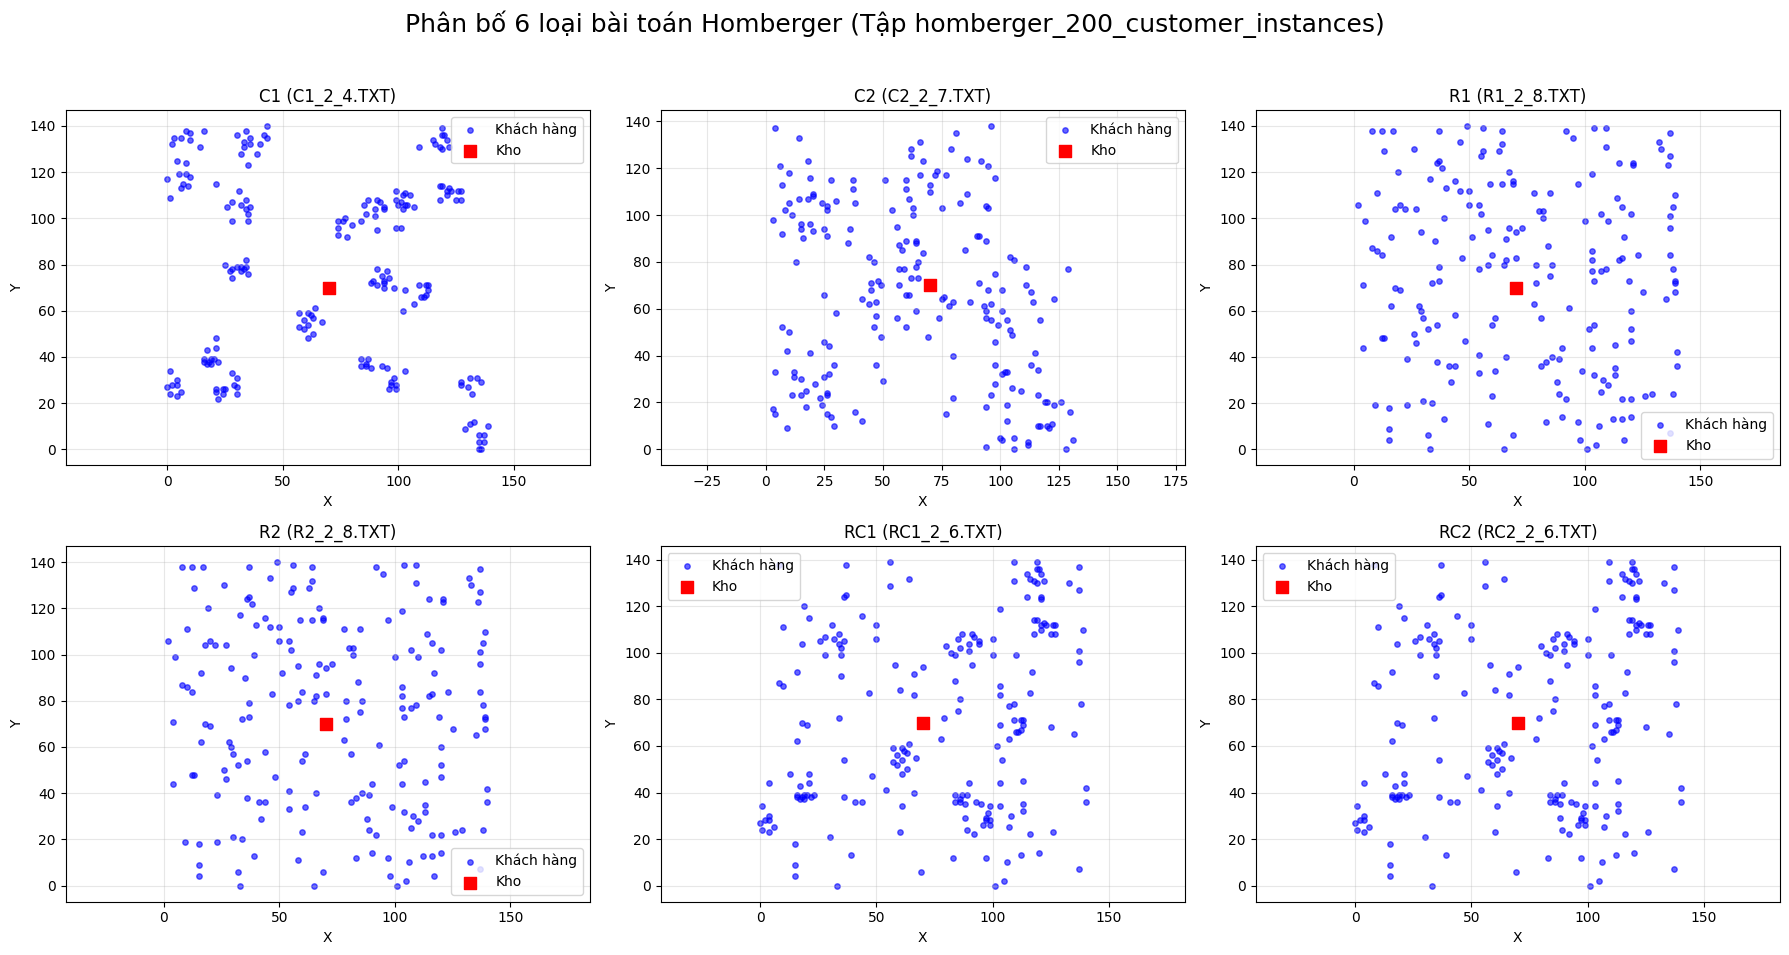

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# --- 1. Cấu hình đường dẫn ---
# (Chọn 1 trong 5 thư mục để trực quan hóa, ví dụ: 200)
BASE_PATH_HOMBERGER = 'vrptw-benchmark/data/Gehring_Homberger/homberger_200_customer_instances/'

# Các tiền tố (prefix) 6 loại file
prefixes = {
    'C1': 'C1_*.TXT',
    'C2': 'C2_*.TXT',
    'R1': 'R1_*.TXT',
    'R2': 'R2_*.TXT',
    'RC1': 'RC1_*.TXT',
    'RC2': 'RC2_*.TXT',
}

# --- 2. Vẽ 6 loại bài toán ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Phân bố 6 loại bài toán Homberger (Tập {os.path.basename(BASE_PATH_HOMBERGER.rstrip("/"))})', fontsize=18)
axes = axes.flatten()

for i, (plot_title, pattern) in enumerate(prefixes.items()):
    ax = axes[i]

    # Tìm file đầu tiên khớp với pattern
    file_list = glob.glob(os.path.join(BASE_PATH_HOMBERGER, pattern))

    if not file_list:
        ax.set_title(f"{plot_title} (Không tìm thấy)", color='red')
        ax.axis('off')
        continue

    file_path = file_list[0] # Lấy file đầu tiên làm đại diện
    fname = os.path.basename(file_path)

    # Tái sử dụng hàm parser từ Cell 1
    df, _ = read_benchmark_file(file_path)

    if df.empty:
        ax.set_title(f"{plot_title} (Lỗi đọc)", color='red')
        ax.axis('off')
        continue

    depot = df[df['CUST_NO'] == 0].iloc[0]
    customers = df[df['CUST_NO'] != 0]

    ax.scatter(customers['XCOORD'], customers['YCOORD'], c='blue', s=15, alpha=0.6, label='Khách hàng')
    ax.scatter(depot['XCOORD'], depot['YCOORD'], c='red', s=80, marker='s', label='Kho')

    ax.set_title(f'{plot_title} ({fname})', fontsize=12)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [ ]:
import os
import pandas as pd

TEST_FILE_PATH = 'vrptw-benchmark/data/Solomon/c101.txt'

print(f"--- 1. Cấu trúc file .txt THÔ (20 dòng đầu) ---")
print(f"File: {TEST_FILE_PATH}\n")

with open(TEST_FILE_PATH, 'r') as f:
    for i in range(20): # In 20 dòng đầu
        line = f.readline()
        if not line: break
        print(line, end='')


print("\n\n" + "="*50)
print(f"\n--- 2. Kết quả sau khi qua Parser (df.head()) ---")

df_test, capacity_test = read_benchmark_file(TEST_FILE_PATH)

if not df_test.empty:
    print(f"(Capacity tìm thấy: {capacity_test})\n")
    print(df_test.head())

    print("\n--- 3. Kiểu dữ liệu (df.info()) ---")
    df_test.info()
else:
    print("LỖI: Parser trả về DataFrame rỗng.")

--- 1. Cấu trúc file .txt THÔ (20 dòng đầu) ---
File: vrptw-benchmark/data/Solomon/c101.txt

C101

VEHICLE
NUMBER     CAPACITY
  25         200

CUSTOMER
CUST NO.  XCOORD.   YCOORD.    DEMAND   READY TIME  DUE DATE   SERVICE   TIME
 
    0      40         50          0          0       1236          0   
    1      45         68         10        912        967         90   
    2      45         70         30        825        870         90   
    3      42         66         10         65        146         90   
    4      42         68         10        727        782         90   
    5      42         65         10         15         67         90   
    6      40         69         20        621        702         90   
    7      40         66         20        170        225         90   
    8      38         68         20        255        324         90   
    9      38         70         10        534        605         90   
   10      35         66         10        357


**📝 Ý nghĩa các cột:**

| Cột | Ý nghĩa | Ví dụ |
|-----|---------|-------|
| **CUST NO.** | Số thứ tự (0 = kho) | 0, 1, 2, 3... |
| **XCOORD, YCOORD** | Tọa độ trên bản đồ | (40, 50), (45, 68)... |
| **DEMAND** | Nhu cầu hàng hóa | 0, 10, 30 (kg/m³) |
| **READY_TIME** | Giờ mở cửa | 912 phút = 15:12 |
| **DUE_DATE** | Giờ đóng cửa | 967 phút = 16:07 |
| **SERVICE_TIME** | Thời gian giao hàng | 90 phút |

**⏰ Time Window (Khung thời gian)**

Ví dụ thực tế:
```python
# Khách hàng 1: Cửa hàng Bách Hóa Xanh
customer_1 = {
    'ready_time': 912,    # 15:12 - Mở cửa
    'due_date': 967,      # 16:07 - Đóng cửa  
    'service_time': 90    # 90 phút giao hàng
}

# Tính toán:
window_width = 967 - 912 = 55 phút     # Khung thời gian
feasible = 55 >= 90 ?   # 55 < 90 → KHÔNG KHẢ THI! ❌

customer_7 = {
    'ready_time': 170,    # 2:50
    'due_date': 400,      # 6:40
    'service_time': 90    # 90 phút
}
window = 400 - 170 = 230 phút > 90 phút → OK!

**🤔 Tại sao Solomon thiết kế khó?**

Mục đích:
- Test algorithm robustness - Xử lý constraints conflict
- Mô phỏng thực tế - Không phải mọi khách đều serve được
- Phân biệt algorithm - Tốt vs xấu
- Trade-off decisions - Serve khách nào, bỏ khách nào

**🎯 Time Window Multiplier**

Công thức: New_Window = Original_Window × Multiplier

| Multiplier | Ý nghĩa | Ví dụ (55 phút) |
| :---: | :--- | :--- |
| **0.5** | Chặt hơn 50% | 27.5 phút |
| **1.0** | Benchmark gốc | 55 phút |
| **1.5** | Lỏng hơn 50% | 82.5 phút |
| **2.0** | Lỏng hơn 100% | 110 phút |

### **Utils**

In [ ]:
import pandas as pd
import math
import random
import copy
import os # Dùng để kiểm tra file

def read_benchmark_file(file_path):
    """
    Hàm parser (phân tích) file .txt mạnh mẽ,
    đọc được cả Solomon và Homberger.
    Nó trả về một DataFrame SẠCH và vehicle_capacity.
    """
    if not os.path.exists(file_path):
        print(f"LỖI: Không tìm thấy file {file_path}")
        return None, None

    with open(file_path, 'r') as f:
        lines = f.readlines()

    vehicle_capacity = None
    customer_data = []
    header_found = False

    # --- 1. Tìm Capacity (hoạt động cho cả 2 loại) ---
    for i, line in enumerate(lines):
        line_upper = line.upper()
        if "CAPACITY" in line_upper:
            parts = line.split()
            if len(parts) > 1 and parts[1].isdigit():
                vehicle_capacity = float(parts[1])
                break
            if i + 1 < len(lines):
                parts_next = lines[i+1].split()
                # Kiểm tra list không rỗng và phần tử cuối là số
                if parts_next and parts_next[-1].isdigit():
                    vehicle_capacity = float(parts_next[-1])
                    break

    if vehicle_capacity is None:
        print(f"Cảnh báo: Không tìm thấy CAPACITY. Dùng mặc định 200.")
        vehicle_capacity = 200.0

    # --- 2. Tìm và Phân tích Dữ liệu Khách hàng ---
    for line in lines:
        line_strip = line.strip()

        if not line_strip: continue

        if "CUST NO." in line_strip.upper():
            header_found = True
            continue

        if header_found:
            parts = line_strip.split()
            # Dòng data phải có ít nhất 7 phần tử và phần tử đầu là số
            if len(parts) >= 7 and parts[0].isdigit():
                customer_data.append({
                    'CUST_NO': int(parts[0]),
                    'XCOORD': float(parts[1]),
                    'YCOORD': float(parts[2]),
                    'DEMAND': float(parts[3]),
                    'READY_TIME': float(parts[4]),
                    'DUE_TIME': float(parts[5]), # Tương ứng với DUE DATE
                    'SERVICE_TIME': float(parts[6])
                })

    if not customer_data:
        print(f"Lỗi: Không đọc được data (CUST NO.) từ {file_path}")
        return None, vehicle_capacity

    df = pd.DataFrame(customer_data)
    return df, vehicle_capacity

class Customer:
    """Lưu trữ thông tin của một điểm (khách hàng hoặc kho)."""
    def __init__(self, data_row):
        # Ép kiểu float() là bắt buộc để tránh lỗi 'str' > 'float'
        self.id = int(data_row['CUST_NO'])
        self.x = float(data_row['XCOORD'])
        self.y = float(data_row['YCOORD'])
        self.demand = float(data_row['DEMAND'])
        self.ready_time = float(data_row['READY_TIME'])
        self.due_time = float(data_row['DUE_TIME'])
        self.service_time = float(data_row['SERVICE_TIME'])

    def __repr__(self):
        """Định dạng cách in ra, ví dụ: C1, C5."""
        return f"C{self.id}"

class Solution:
    """
    Lưu trữ một giải pháp hoàn chỉnh (routes và cost).
    """
    def __init__(self, routes):
        self.routes = routes
        self.total_cost = 0.0
        self.total_time_violation = 0.0
        self.total_capacity_violation = 0.0

def calculate_distance(cust1, cust2):
    """Tính khoảng cách Euclidean giữa 2 đối tượng Customer."""
    return math.sqrt((cust1.x - cust2.x)**2 + (cust1.y - cust2.y)**2)

def load_benchmark_data(df):
    """
    ( ✨ ĐÃ CẬP NHẬT ✨ )
    Chuyển đổi DataFrame (đã sạch) thành các đối tượng Depot và Customer.
    """
    customer_objects = []
    # DataFrame đã sạch, chỉ cần lặp và tạo object
    for index, row in df.iterrows():
        customer_objects.append(Customer(row))

    depot = customer_objects[0]     # Khách hàng 0 luôn là kho
    customers = customer_objects[1:]  # Các khách hàng còn lại

    return depot, customers

def evaluate_route(route, depot, vehicle_capacity):
    """
    Đánh giá một route đơn lẻ (1 xe).
    Đây là hàm kiểm tra ràng buộc (constraints) cốt lõi.
    """
    route_cost = 0.0
    route_demand = 0.0
    current_time = 0.0
    time_violation = 0.0
    capacity_violation = 0.0
    last_node = depot

    for cust in route:
        travel_time = calculate_distance(last_node, cust)
        route_cost += travel_time

        arrival_time = current_time + travel_time
        current_time = max(arrival_time, cust.ready_time)

        if current_time > cust.due_time:
            time_violation += (current_time - cust.due_time)

        current_time += cust.service_time
        route_demand += cust.demand
        last_node = cust

    travel_time_to_depot = calculate_distance(last_node, depot)
    route_cost += travel_time_to_depot
    current_time += travel_time_to_depot

    if current_time > depot.due_time:
        time_violation += (current_time - depot.due_time)

    if route_demand > vehicle_capacity:
        capacity_violation = route_demand - vehicle_capacity

    return route_cost, time_violation, capacity_violation

def evaluate_solution(solution, depot, vehicle_capacity):
    """
    Đánh giá toàn bộ giải pháp (nhiều routes).
    Cập nhật các giá trị cost, violation cho đối tượng Solution.
    """
    total_cost = 0.0
    total_time_violation = 0.0
    total_capacity_violation = 0.0
    valid_routes = []

    for route in solution.routes:
        if not route: # Bỏ qua route rỗng
            continue

        cost, time_v, cap_v = evaluate_route(route, depot, vehicle_capacity)
        total_cost += cost
        total_time_violation += time_v
        total_capacity_violation += cap_v
        valid_routes.append(route)

    solution.routes = valid_routes
    solution.total_cost = total_cost
    solution.total_time_violation = total_time_violation
    solution.total_capacity_violation = total_capacity_violation

def create_initial_solution(depot, customers, vehicle_capacity):
    """
    Tạo giải pháp ban đầu bằng Heuristic Chèn Tuần tự (Sequential Insertion).
    """
    routes = []
    customers_copy = list(customers)
    random.shuffle(customers_copy)
    unserved_customers = set(customers_copy)

    while unserved_customers:
        new_route = []
        current_load = 0
        current_time = 0.0
        last_node = depot

        for cust in list(unserved_customers):
            travel_time = calculate_distance(last_node, cust)
            arrival_time = current_time + travel_time
            service_start_time = max(arrival_time, cust.ready_time)

            can_serve = (current_load + cust.demand <= vehicle_capacity) and \
                        (service_start_time <= cust.due_time)

            if can_serve:
                time_back_to_depot = calculate_distance(cust, depot)
                service_end_time = service_start_time + cust.service_time
                arrival_at_depot = service_end_time + time_back_to_depot

                can_return_to_depot = (arrival_at_depot <= depot.due_time)

                if can_return_to_depot:
                    new_route.append(cust)
                    unserved_customers.remove(cust)
                    current_load += cust.demand
                    current_time = service_end_time
                    last_node = cust

        if new_route:
            routes.append(new_route)

        if not new_route and unserved_customers:
            print(f"Cảnh báo: Không thể phục vụ {len(unserved_customers)} khách hàng.")
            break

    initial_sol = Solution(routes)
    evaluate_solution(initial_sol, depot, vehicle_capacity)
    return initial_sol

In [ ]:
import pandas as pd
import random
import math
import copy

# --- CẤU HÌNH THỬ NGHIỆM (SOLOMON C101.txt) ---
DATA_PATH = 'vrptw-benchmark/data/Solomon/c101.txt'

# --- 1. Tải và Chuẩn hóa Dữ liệu ---
print(f"--- 1. Đang đọc và phân tích file: {DATA_PATH} ---")
df, capacity = read_benchmark_file(DATA_PATH)

# Kiểm tra xem file đã được đọc thành công chưa
if df is not None:
    print(f"Đã tìm thấy Capacity: {capacity}")
    print(df.head())
    print("---")

    # --- 2. Tạo Đối tượng Bài toán ---
    print("--- 2. Đang tạo đối tượng (Depot, Customers) ---")
    depot, customers = load_benchmark_data(df)
    print(f"Đã load Depot (ID {depot.id}) và {len(customers)} khách hàng.")
    print("---")

    # --- 3. Tạo Giải pháp Ban đầu ---
    print("--- 3. Đang tạo giải pháp ban đầu... ---")
    initial_solution = create_initial_solution(depot, customers, capacity)

    print("\n--- Kết quả Giải pháp Ban đầu ---")
    print(f"Tổng chi phí (Quãng đường): {initial_solution.total_cost:.2f}")
    print(f"Số xe sử dụng: {len(initial_solution.routes)}")
    print(f"Vi phạm Time Window: {initial_solution.total_time_violation}")
    print(f"Vi phạm Capacity: {initial_solution.total_capacity_violation}")
else:
    print(f"LỖI: Không thể đọc hoặc xử lý file {DATA_PATH}.")

--- 1. Đang đọc và phân tích file: vrptw-benchmark/data/Solomon/c101.txt ---
Đã tìm thấy Capacity: 200.0
   CUST_NO  XCOORD  YCOORD  DEMAND  READY_TIME  DUE_TIME  SERVICE_TIME
0        0    40.0    50.0     0.0         0.0    1236.0           0.0
1        1    45.0    68.0    10.0       912.0     967.0          90.0
2        2    45.0    70.0    30.0       825.0     870.0          90.0
3        3    42.0    66.0    10.0        65.0     146.0          90.0
4        4    42.0    68.0    10.0       727.0     782.0          90.0
---
--- 2. Đang tạo đối tượng (Depot, Customers) ---
Đã load Depot (ID 0) và 100 khách hàng.
---
--- 3. Đang tạo giải pháp ban đầu... ---

--- Kết quả Giải pháp Ban đầu ---
Tổng chi phí (Quãng đường): 3853.68
Số xe sử dụng: 26
Vi phạm Time Window: 0.0
Vi phạm Capacity: 0.0


### **Baseline ALNS**

In [ ]:
import pandas as pd
import math
import random
import copy

# --- 5. Toán tử "Destroy" (Phá vỡ) ---

def random_removal(solution, depot, capacity, num_to_remove):
    """
    Xóa ngẫu nhiên 'num_to_remove' khách hàng khỏi giải pháp.
    """
    all_customers_in_routes = []
    for route in solution.routes:
        for cust in route:
            all_customers_in_routes.append(cust)

    if len(all_customers_in_routes) == 0:
        return []

    num_to_remove = min(num_to_remove, len(all_customers_in_routes))
    customers_to_remove = random.sample(all_customers_in_routes, num_to_remove)

    removed_customers_set = set(customers_to_remove)

    new_routes = []
    for route in solution.routes:
        new_route = []
        for cust in route:
            if cust not in removed_customers_set:
                new_route.append(cust)

        if new_route: # Chỉ thêm route nếu nó không rỗng
            new_routes.append(new_route)

    solution.routes = new_routes
    return customers_to_remove # Trả về danh sách KH cần được chèn lại

def route_removal(solution, depot, capacity, num_routes_to_remove):
    """
    Toán tử phá vỡ 'lớn': Xóa toàn bộ khách hàng trong 'n' routes ngẫu nhiên.
    """
    if len(solution.routes) == 0:
        return []

    num_to_remove = min(num_routes_to_remove, len(solution.routes))

    # Sắp xếp các routes (ví dụ: từ ngắn nhất) để ưu tiên xóa
    sorted_routes = sorted(solution.routes, key=len)

    customers_to_remove = []
    new_routes = []

    for i in range(len(sorted_routes)):
        if i < num_to_remove:
            customers_to_remove.extend(sorted_routes[i])
        else:
            new_routes.append(sorted_routes[i])

    solution.routes = new_routes
    return customers_to_remove

# --- 6. Toán tử "Repair" (Sửa chữa) ---

def greedy_insertion(solution, customers_to_insert, depot, capacity):
    """
    Chèn lại các khách hàng vào vị trí 'tốt nhất' (chi phí tăng ít nhất)
    và hợp lệ (không vi phạm time/capacity).
    """
    random.shuffle(customers_to_insert)

    for cust in customers_to_insert:
        best_route_idx = -1
        best_position_idx = -1
        min_cost_increase = float('inf')

        # Thử chèn 'cust' vào MỌI VỊ TRÍ có thể
        for r_idx, route in enumerate(solution.routes):
            # Lấy chi phí hiện tại của route này
            old_cost, _, _ = evaluate_route(route, depot, capacity)

            for p_idx in range(len(route) + 1):

                new_route = route[:p_idx] + [cust] + route[p_idx:]
                new_cost, time_v, cap_v = evaluate_route(new_route, depot, capacity)

                # Kiểm tra: Phải HOÀN TOÀN HỢP LỆ
                if time_v == 0 and cap_v == 0:
                    cost_increase = new_cost - old_cost

                    if cost_increase < min_cost_increase:
                        min_cost_increase = cost_increase
                        best_route_idx = r_idx
                        best_position_idx = p_idx

        # Sau khi quét hết các route, chèn vào vị trí tốt nhất
        if best_route_idx != -1:
            solution.routes[best_route_idx].insert(best_position_idx, cust)
        else:
            # Nếu không tìm được chỗ nào hợp lệ, TẠO ROUTE MỚI
            new_route = [cust]
            cost, time_v, cap_v = evaluate_route(new_route, depot, capacity)
            if time_v == 0 and cap_v == 0:
                solution.routes.append(new_route)
            else:
                pass # Bỏ qua nếu không thể chèn

    evaluate_solution(solution, depot, capacity)

# --- 7. Bộ chọn Toán tử (Roulette Wheel) ---
def select_operator_roulette(weights):
    """Chọn một index toán tử dựa trên trọng số (weights)."""
    total_weight = sum(weights)
    if total_weight == 0:
        return random.randrange(len(weights))

    pick = random.uniform(0, total_weight)
    current = 0
    for i, weight in enumerate(weights):
        current += weight
        if pick <= current:
            return i
    return len(weights) - 1

# --- 8. Vòng lặp ALNS (Baseline Chuẩn) ---

def run_adaptive_alns(initial_solution, depot, capacity, iterations=1000):

    # --- Cấu hình ALNS ---
    destroy_operators = [random_removal, route_removal]
    repair_operators = [greedy_insertion]

    # Điểm thưởng
    R1 = 5  # Tìm thấy Global Best
    R2 = 2  # Tìm thấy Local Improvement
    R3 = 1  # Chấp nhận giải pháp Tệ hơn (SA)

    # Tham số học (Adaptive weights)
    reaction_factor = 0.1
    destroy_weights = [1.0] * len(destroy_operators)
    repair_weights = [1.0] * len(repair_operators)
    destroy_scores = [0.0] * len(destroy_operators)
    repair_scores = [0.0] * len(repair_operators)
    destroy_uses = [0] * len(destroy_operators)
    repair_uses = [0] * len(repair_operators)
    segment_length = 100

    # Tham số Simulated Annealing (SA)
    start_temp = 100.0
    end_temp = 0.1

    # --- Khởi tạo ---
    current_solution = copy.deepcopy(initial_solution)
    best_solution = copy.deepcopy(initial_solution)

    history = []
    print(f"Bắt đầu ALNS... Chi phí ban đầu: {best_solution.total_cost:.2f}")

    # --- Vòng lặp chính ---
    for i in range(1, iterations + 1):

        new_solution = copy.deepcopy(current_solution)

        d_idx = select_operator_roulette(destroy_weights)
        r_idx = select_operator_roulette(repair_weights)

        destroy_op = destroy_operators[d_idx]
        repair_op = repair_operators[r_idx]

        # Thực thi Destroy & Repair
        if destroy_op == random_removal:
            num_to_remove = random.randint(10, 25) # Phá nhỏ
            removed_customers = destroy_op(new_solution, depot, capacity, num_to_remove)
        else: # route_removal
            num_routes_to_remove = random.randint(1, 3) # Phá lớn
            removed_customers = destroy_op(new_solution, depot, capacity, num_routes_to_remove)

        repair_op(new_solution, removed_customers, depot, capacity)

        new_cost = new_solution.total_cost
        curr_cost = current_solution.total_cost
        best_cost = best_solution.total_cost

        score = 0

        if new_cost < best_cost:
            current_solution = copy.deepcopy(new_solution)
            best_solution = copy.deepcopy(new_solution)
            score = R1
        elif new_cost < curr_cost:
            current_solution = copy.deepcopy(new_solution)
            score = R2
        else:
            delta = new_cost - curr_cost
            temp = start_temp * (end_temp / start_temp)**(i / iterations)

            if math.exp(-delta / temp) > random.random():
                current_solution = copy.deepcopy(new_solution)
                score = R3

        # Cập nhật scores và uses cho adaptive
        destroy_scores[d_idx] += score
        destroy_uses[d_idx] += 1
        repair_scores[r_idx] += score
        repair_uses[r_idx] += 1

        # Cập nhật Weights (sau mỗi segment)
        if i % segment_length == 0:
            for op_i in range(len(destroy_weights)):
                if destroy_uses[op_i] > 0:
                    avg_score = destroy_scores[op_i] / destroy_uses[op_i]
                    destroy_weights[op_i] = (1 - reaction_factor) * destroy_weights[op_i] + \
                                            reaction_factor * avg_score
            # Reset
            destroy_scores = [0.0] * len(destroy_operators)
            destroy_uses = [0] * len(destroy_operators)
            repair_weights = [1.0] * len(repair_operators) # (Giữ nguyên)

        # In tiến trình
        history.append(best_solution.total_cost)
        if i % 100 == 0:
            print(f"Iter {i}/{iterations} - Best Cost: {best_solution.total_cost:.2f} (Current: {current_solution.total_cost:.2f})")

    print(f"--- Hoàn thành ALNS ---")
    return best_solution, history

--- 1. Đang đọc và phân tích file: vrptw-benchmark/data/Solomon/c101.txt ---
Đã tìm thấy Capacity: 200.0
Đã load Depot (ID 0) và 100 khách hàng.
---
--- Kết quả Giải pháp Ban đầu (TRƯỚC ALNS) ---
Tổng chi phí: 3965.57
Số xe sử dụng: 22
---
Bắt đầu ALNS... Chi phí ban đầu: 3965.57
Iter 100/2000 - Best Cost: 1291.65 (Current: 1323.37)
Iter 200/2000 - Best Cost: 1056.71 (Current: 1070.02)
Iter 300/2000 - Best Cost: 952.12 (Current: 952.12)
Iter 400/2000 - Best Cost: 863.75 (Current: 863.75)
Iter 500/2000 - Best Cost: 863.75 (Current: 888.92)
Iter 600/2000 - Best Cost: 863.75 (Current: 891.95)
Iter 700/2000 - Best Cost: 863.75 (Current: 890.02)
Iter 800/2000 - Best Cost: 863.75 (Current: 890.02)
Iter 900/2000 - Best Cost: 863.75 (Current: 863.75)
Iter 1000/2000 - Best Cost: 863.75 (Current: 863.75)
Iter 1100/2000 - Best Cost: 863.75 (Current: 864.64)
Iter 1200/2000 - Best Cost: 863.75 (Current: 864.64)
Iter 1300/2000 - Best Cost: 863.75 (Current: 864.64)
Iter 1400/2000 - Best Cost: 863.54 

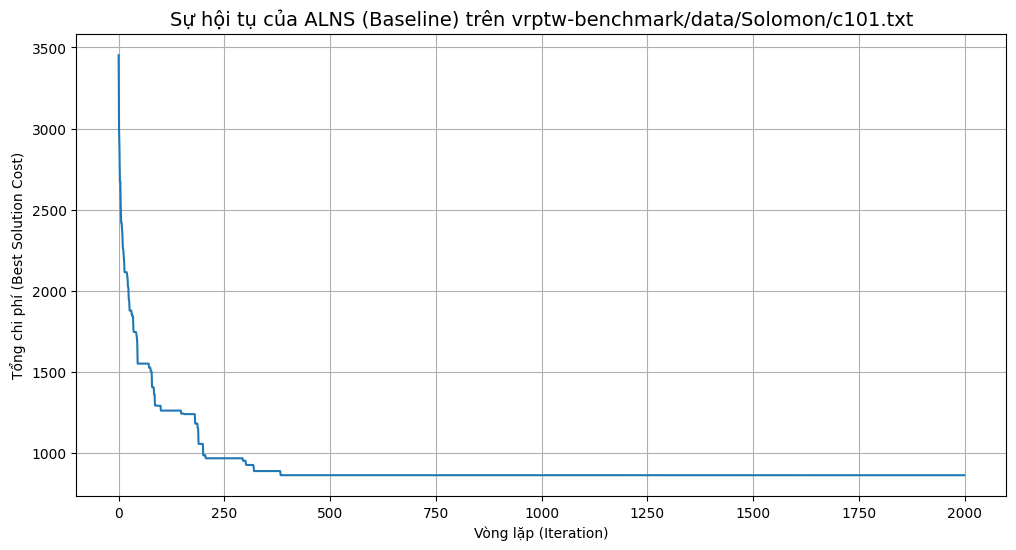

In [ ]:
import matplotlib.pyplot as plt
import time

# --- CẤU HÌNH THỬ NGHIỆM (SOLOMON C101.txt) ---
DATA_PATH = 'vrptw-benchmark/data/Solomon/c101.txt'
ITERATIONS = 2000

# --- 1. Tải và Chuẩn hóa Dữ liệu ---
print(f"--- 1. Đang đọc và phân tích file: {DATA_PATH} ---")
# ( ✨ ĐÂY LÀ PHẦN CẬP NHẬT QUAN TRỌNG ✨ )
df, capacity = read_benchmark_file(DATA_PATH)

if df is not None:
    # --- 2. Tạo Đối tượng Bài toán ---
    print(f"Đã tìm thấy Capacity: {capacity}")
    depot, customers = load_benchmark_data(df)
    print(f"Đã load Depot (ID {depot.id}) và {len(customers)} khách hàng.")
    print("---")

    # --- 3. Tạo Giải pháp Ban đầu ---
    random.seed(42) # Set seed để so sánh công bằng
    initial_solution = create_initial_solution(depot, customers, capacity)

    print("--- Kết quả Giải pháp Ban đầu (TRƯỚC ALNS) ---")
    print(f"Tổng chi phí: {initial_solution.total_cost:.2f}")
    print(f"Số xe sử dụng: {len(initial_solution.routes)}")
    print("---")

    # --- 4. Chạy ALNS ---
    # (Hàm run_adaptive_alns không đổi, chỉ cần truyền đúng)
    start_time = time.time()

    final_solution, cost_history = run_adaptive_alns(
        initial_solution,
        depot,
        capacity,
        iterations=ITERATIONS
    )

    end_time = time.time()
    print(f"Tổng thời gian chạy ALNS: {end_time - start_time:.2f} giây")

    # --- 5. In Kết quả Cuối cùng ---
    print("\n--- Kết quả Cuối cùng (SAU ALNS) ---")
    print(f"Tổng chi phí: {final_solution.total_cost:.2f}")
    print(f"Số xe sử dụng: {len(final_solution.routes)}")

    # --- 6. Vẽ Biểu đồ Hội tụ ---
    plt.figure(figsize=(12, 6))
    plt.plot(cost_history)
    plt.title(f'Sự hội tụ của ALNS (Baseline) trên {DATA_PATH}', fontsize=14)
    plt.xlabel('Vòng lặp (Iteration)')
    plt.ylabel('Tổng chi phí (Best Solution Cost)')
    plt.grid(True)
    plt.show()
else:
    print(f"LỖI: Không thể chạy ALNS vì file {DATA_PATH} đọc thất bại.")

### **ALNS + DQN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import collections

# --- 9. Thành phần Lõi DQN ---

class QNetwork(nn.Module):
    """Kiến trúc mạng Neural (Bộ não)."""
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(state_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # Trả về Q-values

class ReplayMemory:
    """Bộ nhớ (Trí nhớ) để lưu trữ các kinh nghiệm."""
    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        experience = (state, action, reward, next_state)
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- 10. Tác nhân DQN (Agent Controller) ---

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, batch_size=64, memory_capacity=10000):
        self.state_size = state_size
        self.action_size = action_size

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"DQN Agent đang sử dụng thiết bị: {self.device}")

        # Khởi tạo 2 mạng: Policy (chính) và Target (ổn định)
        self.policy_net = QNetwork(state_size, action_size).to(self.device)
        self.target_net = QNetwork(state_size, action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Target net chỉ để đánh giá

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayMemory(memory_capacity)

        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = 100 # Cập nhật target net sau 100 bước
        self.steps_done = 0

    def select_action(self, state, epsilon):
        """Chọn hành động bằng Epsilon-Greedy."""
        self.steps_done += 1
        if random.random() > epsilon:
            # Khai thác: Chọn hành động tốt nhất
            with torch.no_grad():
                state_tensor = torch.tensor([state], dtype=torch.float32).to(self.device)
                action = self.policy_net(state_tensor).max(1)[1].view(1, 1)
                return action.item() # Trả về index (0 hoặc 1)
        else:
            # Khám phá: Chọn ngẫu nhiên
            return random.randrange(self.action_size)

    def store_transition(self, state, action, reward, next_state):
        """Lưu kinh nghiệm vào bộ nhớ."""
        self.memory.push(state, action, reward, next_state)

    def train_step(self):
        """Thực hiện một bước huấn luyện (học từ kinh nghiệm)."""
        if len(self.memory) < self.batch_size:
            return # Chưa đủ kinh nghiệm để học

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        state_batch = torch.tensor(states, dtype=torch.float32).to(self.device)
        action_batch = torch.tensor(actions, dtype=torch.int64).to(self.device).unsqueeze(1)
        reward_batch = torch.tensor(rewards, dtype=torch.float32).to(self.device).unsqueeze(1)
        next_state_batch = torch.tensor(next_states, dtype=torch.float32).to(self.device)

        # Tính Q(s, a) (Giá trị Q hiện tại)
        q_values = self.policy_net(state_batch).gather(1, action_batch)

        # Tính V(s') (Giá trị Q kỳ vọng từ trạng thái tiếp theo)
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0].unsqueeze(1)

        # Công thức Bellman: expected = reward + gamma * next_q
        expected_q_values = reward_batch + (self.gamma * next_q_values)

        loss = F.mse_loss(q_values, expected_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Cập nhật Target Network
        if self.steps_done % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, path):
        """Lưu lại bộ não (trọng số) đã huấn luyện."""
        # Đảm bảo lưu bằng thư viện safetensors
        from safetensors.torch import save_file
        save_file(self.policy_net.state_dict(), path)

# --- 11. Vòng lặp ALNS + DQN ---

def get_state(current_cost, best_cost, iterations_since_best):
    """
    Hàm trợ giúp: Định nghĩa "Trạng thái" (State)
    Trả về một vector [feature1, feature2, ...]
    """
    # Feature 1: Chi phí hiện tại đã được chuẩn hóa
    cost_diff = (current_cost - best_cost) / best_cost if best_cost > 0 else 0

    # Feature 2: "Sự bế tắc" đã được chuẩn hóa
    stuck_norm = iterations_since_best / 100.0

    return [cost_diff, stuck_norm]

def run_dqn_alns(initial_solution, depot, capacity, iterations=1000, model_save_path="dqn_model.safetensor"):

    # --- Cấu hình DQN ---
    # (Giả định các hàm destroy/repair đã được định nghĩa ở cell Baseline)
    destroy_operators = [random_removal, route_removal]
    repair_op = greedy_insertion

    STATE_SIZE = 2 # 2 features: [cost_diff, stuck_norm]
    ACTION_SIZE = len(destroy_operators) # 2 actions: [0, 1]

    agent = DQNAgent(STATE_SIZE, ACTION_SIZE)

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995 # Epsilon giảm dần

    R1 = 5  # Tìm thấy Global Best
    R2 = 2  # Tìm thấy Local Improvement
    R3 = 1  # Chấp nhận giải pháp Tệ hơn (SA)

    start_temp = 100.0
    end_temp = 0.1

    # --- Khởi tạo ---
    current_solution = copy.deepcopy(initial_solution)
    best_solution = copy.deepcopy(initial_solution)

    iterations_since_best = 0
    epsilon = epsilon_start

    history = []
    print(f"Bắt đầu DQN-ALNS... Chi phí ban đầu: {best_solution.total_cost:.2f}")

    # --- Vòng lặp chính ---
    for i in range(1, iterations + 1):

        state = get_state(current_solution.total_cost, best_solution.total_cost, iterations_since_best)

        action_idx = agent.select_action(state, epsilon)
        destroy_op = destroy_operators[action_idx]

        new_solution = copy.deepcopy(current_solution)

        if destroy_op == random_removal:
            num_to_remove = random.randint(10, 25)
            removed = destroy_op(new_solution, depot, capacity, num_to_remove)
        else: # route_removal
            num_routes_to_remove = random.randint(1, 3)
            removed = destroy_op(new_solution, depot, capacity, num_routes_to_remove)

        repair_op(new_solution, removed, depot, capacity)

        new_cost = new_solution.total_cost
        curr_cost = current_solution.total_cost
        best_cost = best_solution.total_cost

        reward = 0
        iterations_since_best += 1

        if new_cost < best_cost:
            current_solution = copy.deepcopy(new_solution)
            best_solution = copy.deepcopy(new_solution)
            reward = R1
            iterations_since_best = 0
        elif new_cost < curr_cost:
            current_solution = copy.deepcopy(new_solution)
            reward = R2
        else:
            delta = new_cost - curr_cost
            temp = start_temp * (end_temp / start_temp)**(i / iterations)
            if math.exp(-delta / temp) > random.random():
                current_solution = copy.deepcopy(new_solution)
                reward = R3

        next_state = get_state(current_solution.total_cost, best_solution.total_cost, iterations_since_best)

        agent.store_transition(state, action_idx, reward, next_state)

        if len(agent.memory) > agent.batch_size:
            agent.train_step()

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        history.append(best_solution.total_cost)
        if i % 100 == 0:
            print(f"Iter {i}/{iterations} - Best Cost: {best_solution.total_cost:.2f} (Epsilon: {epsilon:.2f})")

    print(f"--- Hoàn thành DQN-ALNS ---")

    # Cài đặt safetensors nếu chưa có
    try:
        import safetensors.torch
    except ImportError:
        print("Đang cài đặt 'safetensors'...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "safetensors"])

    agent.save_model(model_save_path)
    print(f"Đã lưu model huấn luyện tại: {model_save_path}")

    return best_solution, history

--- 1. Đang đọc và phân tích file: vrptw-benchmark/data/Solomon/c101.txt ---
Đã tìm thấy Capacity: 200.0
Đã load Depot (ID 0) và 100 khách hàng.
---
--- Kết quả Giải pháp Ban đầu (TRƯỚC DQN-ALNS) ---
Tổng chi phí: 3426.39
Số xe sử dụng: 23
---
DQN Agent đang sử dụng thiết bị: cuda
Bắt đầu DQN-ALNS... Chi phí ban đầu: 3426.39
Iter 100/2000 - Best Cost: 1150.66 (Epsilon: 0.61)
Iter 200/2000 - Best Cost: 936.64 (Epsilon: 0.37)
Iter 300/2000 - Best Cost: 828.94 (Epsilon: 0.22)
Iter 400/2000 - Best Cost: 828.94 (Epsilon: 0.13)
Iter 500/2000 - Best Cost: 828.94 (Epsilon: 0.08)
Iter 600/2000 - Best Cost: 828.94 (Epsilon: 0.05)
Iter 700/2000 - Best Cost: 828.94 (Epsilon: 0.03)
Iter 800/2000 - Best Cost: 828.94 (Epsilon: 0.02)
Iter 900/2000 - Best Cost: 828.94 (Epsilon: 0.01)
Iter 1000/2000 - Best Cost: 828.94 (Epsilon: 0.01)
Iter 1100/2000 - Best Cost: 828.94 (Epsilon: 0.01)
Iter 1200/2000 - Best Cost: 828.94 (Epsilon: 0.01)
Iter 1300/2000 - Best Cost: 828.94 (Epsilon: 0.01)
Iter 1400/2000 - B

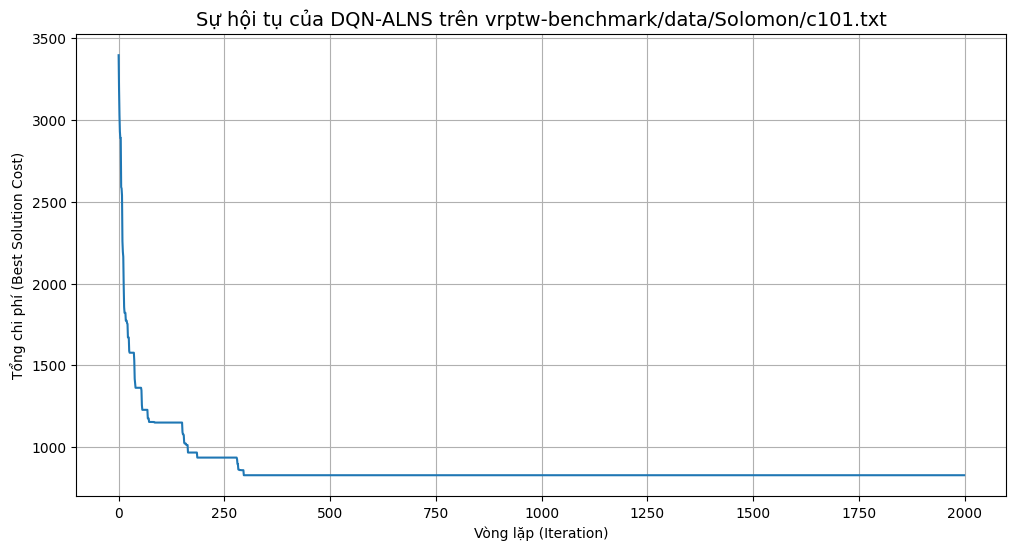

In [ ]:
import matplotlib.pyplot as plt
import time

# --- CẤU HÌNH THỬ NGHIỆM (SOLOMON C101.txt) ---
DATA_PATH = 'vrptw-benchmark/data/Solomon/c101.txt'
ITERATIONS = 2000
MODEL_SAVE_PATH = 'dqn_alns_c101.safetensor'

# --- 1. Tải và Chuẩn hóa Dữ liệu ---
print(f"--- 1. Đang đọc và phân tích file: {DATA_PATH} ---")
# ( ✨ ĐÂY LÀ PHẦN CẬP NHẬT QUAN TRỌNG ✨ )
df, capacity = read_benchmark_file(DATA_PATH)

if df is not None:
    # --- 2. Tạo Đối tượng Bài toán ---
    print(f"Đã tìm thấy Capacity: {capacity}")
    depot, customers = load_benchmark_data(df)
    print(f"Đã load Depot (ID {depot.id}) và {len(customers)} khách hàng.")
    print("---")

    # --- 3. Tạo Giải pháp Ban đầu ---
    random.seed(42) # Set seed để so sánh công bằng
    initial_solution = create_initial_solution(depot, customers, capacity)

    print("--- Kết quả Giải pháp Ban đầu (TRƯỚC DQN-ALNS) ---")
    print(f"Tổng chi phí: {initial_solution.total_cost:.2f}")
    print(f"Số xe sử dụng: {len(initial_solution.routes)}")
    print("---")

    # --- 4. Chạy DQN-ALNS ---
    start_time = time.time()

    final_solution, cost_history = run_dqn_alns(
        initial_solution,
        depot,
        capacity,
        iterations=ITERATIONS,
        model_save_path=MODEL_SAVE_PATH
    )

    end_time = time.time()
    print(f"Tổng thời gian chạy DQN-ALNS: {end_time - start_time:.2f} giây")

    # --- 5. In Kết quả Cuối cùng ---
    print("\n--- Kết quả Cuối cùng (SAU DQN-ALNS) ---")
    print(f"Tổng chi phí: {final_solution.total_cost:.2f}")
    print(f"Số xe sử dụng: {len(final_solution.routes)}")

    # --- 6. Vẽ Biểu đồ Hội tụ ---
    plt.figure(figsize=(12, 6))
    plt.plot(cost_history)
    plt.title(f'Sự hội tụ của DQN-ALNS trên {DATA_PATH}', fontsize=14)
    plt.xlabel('Vòng lặp (Iteration)')
    plt.ylabel('Tổng chi phí (Best Solution Cost)')
    plt.grid(True)
    plt.show()
else:
    print(f"LỖI: Không thể chạy DQN-ALNS vì file {DATA_PATH} đọc thất bại.")

### **Compare**

In [ ]:
# @title
import pandas as pd
import time
import glob
import os
import copy
import random
import matplotlib.pyplot as plt

# --- 1. TỰ ĐỘNG XÂY DỰNG BỘ THỬ NGHIỆM (TEST SET) ---

def build_test_set():
    """
    Tự động quét các thư mục benchmark để tìm tất cả các file .txt/.TXT
    """
    BASE_PATH_SOLOMON = 'vrptw-benchmark/data/Solomon/'
    BASE_PATH_HOMBERGER = 'vrptw-benchmark/data/Gehring_Homberger/'

    # Quét Solomon (.txt chữ thường)
    solomon_files = glob.glob(f"{BASE_PATH_SOLOMON}/*.txt")

    # Quét Homberger (.TXT chữ hoa, quét đệ quy)
    homberger_files = glob.glob(f"{BASE_PATH_HOMBERGER}/**/*.TXT", recursive=True)

    all_files = solomon_files + homberger_files
    all_files.sort()

    test_set = {}
    for file_path in all_files:
        # Lấy tên file (ví dụ: c101) hoặc tên thư mục/file (C1_2_1)
        if BASE_PATH_HOMBERGER in file_path:
             # Tạo tên unique cho Homberger, ví dụ: "200_C1_2_1"
            parent_dir = os.path.basename(os.path.dirname(file_path))
            file_name = os.path.basename(file_path).split('.')[0]
            problem_name = f"{parent_dir.split('_')[1]}_{file_name}"
        else:
            problem_name = os.path.basename(file_path).split('.')[0]

        test_set[problem_name] = {'path': file_path}

    return test_set

TEST_SET = build_test_set()

print(f"--- Đã tự động tìm thấy {len(TEST_SET)} file benchmark ---")

# Cấu hình số vòng lặp
ITERATIONS = 2000

# --- 2. CHẠY SO SÁNH TỰ ĐỘNG ---
comparison_results = []

print(f"--- BẮT ĐẦU CHẠY SO SÁNH (TOÀN BỘ {len(TEST_SET)} FILES) ---")

for problem_name, config in TEST_SET.items():

    print(f"\n--- Đang xử lý: {problem_name} ---")

    # 1. Tải dữ liệu ( ✨ LOGIC MỚI ✨ )
    # (Dùng hàm parser .txt từ Cell 1 (Utils))
    df, capacity = read_benchmark_file(config['path'])

    # Kiểm tra xem file có đọc được không
    if df is None or capacity is None:
        print(f"Lỗi đọc file {config['path']}. Bỏ qua...")
        continue

    print(f"File: {config['path']}, Capacity tìm thấy: {capacity}")
    depot, customers = load_benchmark_data(df)

    # 2. Tạo MỘT giải pháp ban đầu
    random.seed(42)
    initial_solution = create_initial_solution(depot, customers, capacity)

    print(f"Giải pháp ban đầu (Cost): {initial_solution.total_cost:.2f}, (Xe): {len(initial_solution.routes)}")

    # --- 3. Chạy Baseline (Adaptive ALNS) ---
    print("...Đang chạy Baseline Adaptive ALNS...")
    start_time_base = time.time()

    baseline_sol, _ = run_adaptive_alns(
        copy.deepcopy(initial_solution),
        depot,
        capacity, # ( ✨ Truyền capacity đã tìm thấy ✨ )
        iterations=ITERATIONS
    )

    time_base = time.time() - start_time_base
    cost_base = baseline_sol.total_cost
    vehicles_base = len(baseline_sol.routes)

    # In log rút gọn
    print(f"Baseline xong. Cost: {cost_base:.2f}, Time: {time_base:.1f}s")

    # --- 4. Chạy DQN-ALNS ---
    print("...Đang chạy DQN-ALNS...")
    start_time_dqn = time.time()

    dqn_sol, _ = run_dqn_alns(
        copy.deepcopy(initial_solution),
        depot,
        capacity, # ( ✨ Truyền capacity đã tìm thấy ✨ )
        iterations=ITERATIONS,
        model_save_path=f"dqn_{problem_name}.safetensor"
    )

    time_dqn = time.time() - start_time_dqn
    cost_dqn = dqn_sol.total_cost
    vehicles_dqn = len(dqn_sol.routes)

    print(f"DQN xong. Cost: {cost_dqn:.2f}, Time: {time_dqn:.1f}s")

    # --- 5. Lưu kết quả ---
    comparison_results.append({
        'Problem': problem_name,
        'Initial Cost': initial_solution.total_cost,
        'Baseline Cost': cost_base,
        'DQN Cost': cost_dqn,
        'Baseline Vehicles': vehicles_base,
        'DQN Vehicles': vehicles_dqn,
        'Baseline Time (s)': time_base,
        'DQN Time (s)': time_dqn
    })

    # (Kết thúc vòng lặp)

# --- 6. In Bảng So sánh Cuối cùng ---
print("\n" + "="*50)
print("--- BẢNG KẾT QUẢ SO SÁNH CUỐI CÙNG (TOÀN BỘ DATASET) ---")

if comparison_results:
    df_results = pd.DataFrame(comparison_results)

    df_results['DQN_vs_Base (%)'] = (
        (df_results['Baseline Cost'] - df_results['DQN Cost']) /
         df_results['Baseline Cost']
    ) * 100

    columns_order = [
        'Problem',
        'Initial Cost',
        'Baseline Cost',
        'DQN Cost',
        'DQN_vs_Base (%)',
        'Baseline Vehicles',
        'DQN Vehicles',
        'Baseline Time (s)',
        'DQN Time (s)'
    ]
    df_results = df_results[columns_order]

    pd.set_option('display.float_format', '{:,.2f}'.format)
    print(df_results)

    # --- 7. In Tóm tắt Trung bình ---
    print("\n" + "="*50)
    print("--- TÓM TẮT TRUNG BÌNH ---")

    # Tính trung bình cải thiện (chỉ tính các trường hợp DQN thắng)
    avg_improvement_positive = df_results[df_results['DQN_vs_Base (%)'] > 0]['DQN_vs_Base (%)'].mean()
    # Tính trung bình chung
    avg_improvement_all = df_results['DQN_vs_Base (%)'].mean()

    avg_time_base = df_results['Baseline Time (s)'].mean()
    avg_time_dqn = df_results['DQN Time (s)'].mean()

    print(f"Cải thiện trung bình (tổng thể): {avg_improvement_all:.2f}%")
    print(f"Cải thiện trung bình (khi DQN thắng): {avg_improvement_positive:.2f}%")
    print(f"Thời gian chạy TB Baseline: {avg_time_base:.2f}s")
    print(f"Thời gian chạy TB DQN: {avg_time_dqn:.2f}s")
else:
    print("Không có kết quả nào để hiển thị. (Kiểm tra lại đường dẫn file)")

--- Đã tự động tìm thấy 356 file benchmark ---
--- BẮT ĐẦU CHẠY SO SÁNH (TOÀN BỘ 356 FILES) ---

--- Đang xử lý: 1000_C1_10_1 ---
File: vrptw-benchmark/data/Gehring_Homberger/homberger_1000_customer_instances/C1_10_1.TXT, Capacity tìm thấy: 200.0
Giải pháp ban đầu (Cost): 179658.83, (Xe): 266
...Đang chạy Baseline Adaptive ALNS...
Bắt đầu ALNS... Chi phí ban đầu: 179658.83
Iter 100/2000 - Best Cost: 115448.21 (Current: 115448.21)
Iter 200/2000 - Best Cost: 96360.60 (Current: 96374.26)
Iter 300/2000 - Best Cost: 84658.37 (Current: 84658.37)
Iter 400/2000 - Best Cost: 78549.87 (Current: 78549.87)
Iter 500/2000 - Best Cost: 73676.18 (Current: 73679.06)
Iter 600/2000 - Best Cost: 71502.54 (Current: 71502.54)
Iter 700/2000 - Best Cost: 70272.47 (Current: 70272.47)
Iter 800/2000 - Best Cost: 69677.07 (Current: 69677.07)
Iter 900/2000 - Best Cost: 68595.31 (Current: 68595.31)
Iter 1000/2000 - Best Cost: 67342.28 (Current: 67342.28)
Iter 1100/2000 - Best Cost: 66680.73 (Current: 66680.73)
Iter

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import time
import glob
import os
import copy
import random
import matplotlib.pyplot as plt

# --- 1. TỰ ĐỘNG XÂY DỰNG BỘ THỬ NGHIỆM (TEST SET) ---

def build_test_set():
    """
    ( ✨ ĐÃ SỬA LẠI: Chỉ chạy 12 file đại diện (6 Solomon + 6 Homberger) ✨ )
    Tạo một bộ thử nghiệm (test set) rút gọn nhưng có tính đại diện.
    """
    BASE_PATH_SOLOMON = 'vrptw-benchmark/data/Solomon/'
    BASE_PATH_HOMBERGER = 'vrptw-benchmark/data/Gehring_Homberger/'

    # Định nghĩa các file đại diện
    representative_files = [
        # Solomon (6 files)
        ('c101', f"{BASE_PATH_SOLOMON}c101.txt"),
        ('c201', f"{BASE_PATH_SOLOMON}c201.txt"),
        ('r101', f"{BASE_PATH_SOLOMON}r101.txt"),
        ('r201', f"{BASE_PATH_SOLOMON}r201.txt"),
        ('rc101', f"{BASE_PATH_SOLOMON}rc101.txt"),
        ('rc201', f"{BASE_PATH_SOLOMON}rc201.txt"),

        # Homberger - 200 (6 files)
        # (Tạo tên unique, ví dụ: "200_C1_2_1")
        ('200_C1_2_1',  f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/C1_2_1.TXT"),
        ('200_C2_2_1',  f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/C2_2_1.TXT"),
        ('200_R1_2_1',  f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/R1_2_1.TXT"),
        ('200_R2_2_1',  f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/R2_2_1.TXT"),
        ('200_RC1_2_1', f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/RC1_2_1.TXT"),
        ('200_RC2_2_1', f"{BASE_PATH_HOMBERGER}homberger_200_customer_instances/RC2_2_1.TXT"),
    ]

    test_set = {}
    for problem_name, file_path in representative_files:
        # Kiểm tra xem file có thực sự tồn tại không
        if os.path.exists(file_path):
            test_set[problem_name] = {'path': file_path}
        else:
            print(f"Cảnh báo: Không tìm thấy file đại diện: {file_path}. Bỏ qua...")

    return test_set

TEST_SET = build_test_set()

print(f"--- Đã tự động tìm thấy {len(TEST_SET)} file benchmark (Bộ đại diện) ---")

# Cấu hình số vòng lặp
ITERATIONS = 2000

# --- 2. CHẠY SO SÁNH TỰ ĐỘNG ---
comparison_results = []

print(f"--- BẮT ĐẦU CHẠY SO SÁNH (TOÀN BỘ {len(TEST_SET)} FILES) ---")

for problem_name, config in TEST_SET.items():

    print(f"\n--- Đang xử lý: {problem_name} ---")

    # 1. Tải dữ liệu
    df, capacity = read_benchmark_file(config['path'])

    if df is None or capacity is None:
        print(f"Lỗi đọc file {config['path']}. Bỏ qua...")
        continue

    print(f"File: {config['path']}, Capacity tìm thấy: {capacity}")
    depot, customers = load_benchmark_data(df)

    # 2. Tạo MỘT giải pháp ban đầu
    random.seed(42)
    initial_solution = create_initial_solution(depot, customers, capacity)

    print(f"Giải pháp ban đầu (Cost): {initial_solution.total_cost:.2f}, (Xe): {len(initial_solution.routes)}")

    # --- 3. Chạy Baseline (Adaptive ALNS) ---
    print("...Đang chạy Baseline Adaptive ALNS...")
    start_time_base = time.time()

    baseline_sol, _ = run_adaptive_alns(
        copy.deepcopy(initial_solution),
        depot,
        capacity,
        iterations=ITERATIONS
    )

    time_base = time.time() - start_time_base
    cost_base = baseline_sol.total_cost
    vehicles_base = len(baseline_sol.routes)

    print(f"Baseline xong. Cost: {cost_base:.2f}, Time: {time_base:.1f}s")

    # --- 4. Chạy DQN-ALNS ---
    print("...Đang chạy DQN-ALNS...")
    start_time_dqn = time.time()

    dqn_sol, _ = run_dqn_alns(
        copy.deepcopy(initial_solution),
        depot,
        capacity,
        iterations=ITERATIONS,
        model_save_path=f"dqn_{problem_name}.safetensor"
    )

    time_dqn = time.time() - start_time_dqn
    cost_dqn = dqn_sol.total_cost
    vehicles_dqn = len(dqn_sol.routes)

    print(f"DQN xong. Cost: {cost_dqn:.2f}, Time: {time_dqn:.1f}s")

    # --- 5. Lưu kết quả ---
    comparison_results.append({
        'Problem': problem_name,
        'Initial Cost': initial_solution.total_cost,
        'Baseline Cost': cost_base,
        'DQN Cost': cost_dqn,
        'Baseline Vehicles': vehicles_base,
        'DQN Vehicles': vehicles_dqn,
        'Baseline Time (s)': time_base,
        'DQN Time (s)': time_dqn
    })

    # (Kết thúc vòng lặp)

# --- 6. In Bảng So sánh Cuối cùng ---
print("\n" + "="*50)
print("--- BẢNG KẾT QUẢ SO SÁNH CUỐI CÙNG (BỘ ĐẠI DIỆN) ---")

if comparison_results:
    df_results = pd.DataFrame(comparison_results)

    df_results['DQN_vs_Base (%)'] = (
        (df_results['Baseline Cost'] - df_results['DQN Cost']) /
         df_results['Baseline Cost']
    ) * 100

    columns_order = [
        'Problem',
        'Initial Cost',
        'Baseline Cost',
        'DQN Cost',
        'DQN_vs_Base (%)',
        'Baseline Vehicles',
        'DQN Vehicles',
        'Baseline Time (s)',
        'DQN Time (s)'
    ]
    df_results = df_results.reindex(columns=columns_order) # Dùng reindex an toàn hơn

    pd.set_option('display.float_format', '{:,.2f}'.format)
    print(df_results)

    # --- 7. In Tóm tắt Trung bình ---
    print("\n" + "="*50)
    print("--- TÓM TẮT TRUNG BÌNH ---")

    avg_improvement_positive = df_results[df_results['DQN_vs_Base (%)'] > 0]['DQN_vs_Base (%)'].mean()
    avg_improvement_all = df_results['DQN_vs_Base (%)'].mean()

    avg_time_base = df_results['Baseline Time (s)'].mean()
    avg_time_dqn = df_results['DQN Time (s)'].mean()

    print(f"Cải thiện trung bình (tổng thể): {avg_improvement_all:.2f}%")
    # Kiểm tra nếu avg_improvement_positive không phải là NaN (tránh lỗi nếu không có DQN nào thắng)
    if pd.notna(avg_improvement_positive):
        print(f"Cải thiện trung bình (khi DQN thắng): {avg_improvement_positive:.2f}%")
    else:
        print("Cải thiện trung bình (khi DQN thắng): 0.00% (DQN không thắng)")

    print(f"Thời gian chạy TB Baseline: {avg_time_base:.2f}s")
    print(f"Thời gian chạy TB DQN: {avg_time_dqn:.2f}s")
else:
    print("Không có kết quả nào để hiển thị. (Kiểm tra lại đường dẫn file)")

--- Đã tự động tìm thấy 12 file benchmark (Bộ đại diện) ---
--- BẮT ĐẦU CHẠY SO SÁNH (TOÀN BỘ 12 FILES) ---

--- Đang xử lý: c101 ---
File: vrptw-benchmark/data/Solomon/c101.txt, Capacity tìm thấy: 200.0
Giải pháp ban đầu (Cost): 4057.00, (Xe): 26
...Đang chạy Baseline Adaptive ALNS...
Bắt đầu ALNS... Chi phí ban đầu: 4057.00
Iter 100/2000 - Best Cost: 1238.24 (Current: 1315.13)
Iter 200/2000 - Best Cost: 1131.38 (Current: 1131.38)
Iter 300/2000 - Best Cost: 1050.43 (Current: 1148.72)
Iter 400/2000 - Best Cost: 1018.28 (Current: 1043.32)
Iter 500/2000 - Best Cost: 955.92 (Current: 955.92)
Iter 600/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 700/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 800/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 900/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 1000/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 1100/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 1200/2000 - Best Cost: 828.94 (Current: 828.94)
Iter 1300/2000 - Best Cost: 828.94 (C

### **Visualize**

**TÓM TẮT KẾT QUẢ BENCHMARK (12 FILES)**

1.  **Hiệu suất (Chi phí):**
    * Kết quả không đồng đều. DQN thắng ở 5/12 file (đặc biệt là C101, C201, 200_C1_2_1) nhưng thua ở 7/12 file (như R101, 200_C2_2_1).
    * Cải thiện tổng thể (TB): 0.50%.
    * **Phát hiện chính:** Khi DQN thắng, nó thắng rất đậm (TB 4.91%, cá biệt 14.52%), chứng tỏ nó có khả năng thoát khỏi điểm tối ưu cục bộ tốt hơn Baseline.

2.  **Thời gian chạy (Tốc độ):**
    * **Phát hiện bất ngờ:** DQN (TB 78.07s) chạy nhanh hơn Baseline (TB 85.79s).
    * Lý do (Giả thuyết): DQN học và loại bỏ các chiến lược (action) tệ sớm hơn, giúp hội tụ nhanh hơn.

3.  **Tài nguyên (Số xe):**
    * DQN cho thấy khả năng tối ưu hóa cả số lượng xe (ví dụ: c201 giảm từ 4 xuống 3 xe).

**Kết luận:** DQN-ALNS là một phương pháp mạnh mẽ, có khả năng tìm ra giải pháp vượt trội (cả về chi phí và số xe) mà Baseline không tìm thấy, đặc biệt trên các bài toán loại (C) Clustered.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# --- 1. Tạo cột màu sắc (Xanh = Thắng, Đỏ = Thua) ---
df_results['Status'] = df_results['DQN_vs_Base (%)'].apply(lambda x: 'Thắng (Tốt hơn)' if x > 0 else 'Thua (Kém hơn)')

fig1 = px.bar(
    df_results,
    x='Problem',
    y='DQN_vs_Base (%)',
    color='Status', # Tô màu dựa trên cột Status
    color_discrete_map={ # Định nghĩa màu
        'Thắng (Tốt hơn)': '#28a745',
        'Thua (Kém hơn)': '#dc3545'
    },
    title='Phần trăm Cải thiện của DQN so với Baseline'
)

# Thêm đường ngang tại y=0
fig1.add_shape(
    type='line',
    x0=-0.5, x1=len(df_results['Problem'])-0.5,
    y0=0, y1=0,
    line=dict(color='Black', width=2)
)

fig1.update_layout(
    xaxis_title='Tên Bài toán (Problem)',
    yaxis_title='Cải thiện (%) (Dương = Tốt hơn)',
    xaxis={'tickangle': -45} # Xoay tên file
)

fig1.show()

In [ ]:
import plotly.express as px
import pandas as pd

# --- 1. Chuẩn bị dữ liệu (Melt) ---
# Chuyển đổi df từ "wide" (2 cột) sang "long" (1 cột)
df_time = df_results.melt(
    id_vars=['Problem'],
    value_vars=['Baseline Time (s)', 'DQN Time (s)'],
    var_name='Algorithm', # Tên cột mới
    value_name='Time (s)'   # Tên cột mới
)

# --- 2. Vẽ biểu đồ cột nhóm ---
fig2 = px.bar(
    df_time,
    x='Problem',
    y='Time (s)',
    color='Algorithm', # Nhóm màu theo 'Algorithm'
    barmode='group',   # Đặt 2 cột cạnh nhau
    title='So sánh Thời gian Chạy (Giây)'
)

fig2.update_layout(
    xaxis_title='Tên Bài toán (Problem)',
    yaxis_title='Thời gian (giây)',
    xaxis={'tickangle': -45}
)

fig2.show()

In [ ]:
import plotly.express as px
import pandas as pd


# --- 1. Tạo cột 'Problem Type' (Loại bài toán) ---
def get_problem_type(problem_name):
    if 'RC' in problem_name.upper():
        return 'Clustered+Random (RC)'
    if 'C' in problem_name.upper():
        return 'Clustered (C)'
    if 'R' in problem_name.upper():
        return 'Random (R)'
    return 'Other'

# (Chỉ tạo cột nếu nó chưa tồn tại)
if 'Problem Type' not in df_results.columns:
    df_results['Problem Type'] = df_results['Problem'].apply(get_problem_type)

# --- 2. Vẽ biểu đồ hộp (Box Plot) ---
fig3 = px.box(
    df_results,
    x='Problem Type',
    y='DQN_vs_Base (%)',
    color='Problem Type', # Tô màu theo nhóm
    points='all',         # Hiển thị tất cả các điểm dữ liệu (12 điểm)
    title='Phân bố Cải thiện (%) theo Loại Bài toán'
)

# Thêm đường ngang tại y=0
fig3.add_shape(
    type='line',
    x0=-0.5, x1=2.5, # (Chỉnh x0, x1 nếu có nhiều hơn 3 nhóm)
    y0=0, y1=0,
    line=dict(color='Black', width=2, dash='dash')
)

fig3.update_layout(
    xaxis_title='Loại Bài toán',
    yaxis_title='Cải thiện (%)'
)

fig3.show()